## <font color='blue'> SDSS catalog with morphological classification of galaxies</font>
    

<p>
<center>
<img width=600 src="https://astro.uchicago.edu/~andrey/classes/a211/img/i_heart_galaxies.PNG"></img>
    
    
    

### <font color='blue'>Background

    
Morphological classification (classification by visual appearance) is an old and frequently used approach in astronomy. Morphological classification of galaxies has been particularly widely used with the scheme developed by Edwin Hubble during his PhD studies at U.Chicago being the most widely used (see, for example, <a href="https://jila.colorado.edu/~pja/astr3830/lecture10.pdf">here</a> for a concise description). 
    
    
Hubble for example arranged his morphological classes into what's called a "tuning fork" diagram thinking that it represented evolutionary sequence from spheroidal galaxies (on the left in the diagram above) to the spiral galaxies on the right. This evolutionary thinking is still reflected in the terms "early type" and "late type" galaxies, even though subsequent studies did not support Hubble's vision for how evolution proceeds. In fact, current models predict that some spiral galaxies evolve into spheroidal galaxies (our Milky Way will do this in a few billion years after it merges with Andromeda galaxy), but the opposite almost never happens. Moreover, not all spiral galaxies will evolve into spheroidals. 
    
Nevertheless, observations of morphological class frequency and its evolution with time provides a very useful window into how galaxies form. 
    

The are two frequently encountered issues with morphological classification:
    
    
* It is subjective and classification by different scientists may result in different classifications for borderline cases.
    
    
* It is difficult or impossible to visually classify hundreds of thousand or millions of galaxies. 
    
    
The first issue can be mitigated if master classification for a certain set of galaxies is done by trained expert astronomers. Alternatively, classification can be done by amateurs or even people with little knowledge of astronomy (but a lot of enthusiasm for it), but with many people classifying each image. Correct results for a given image can then be estimated from statistics of multiple classifications.  
    
    
Regardless of how reliable classification is obtained for a set of galaxies, it can then be used as a training set to train a machine learning algorithm, which can then be used to classify a large number of new images with accuracy comparable to the original classification in the training set. 
    

In this project you will undertake this latter step using some supervised and unsupervised machine learning methods. 

### <font color='blue'>UPenn catalog of SDSS galaxies 

You will use the <a href="http://www.physics.upenn.edu/~ameert/SDSS_PhotDec/download/">UPenn catalog of SDSS galaxies</a>. This catalog contains improved measurements of photometric properties of galaxies  (<a href="http://adsabs.harvard.edu/abs/2015MNRAS.446.3943M">Meert et al. 2015</a>). The catalog files are available  <a href="https://astro.uchicago.edu/~andrey/classes/a211/data/Meert2015_v2/">here</a>. The code below reads data directly from our department server. You may also download the files to your laptop, and then change the <tt>url</tt> parameter of the function below to the path to a local directory where you stored the catalog files.  

In [73]:
import numpy as np
from timeit import default_timer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns # to plot the confusion matrix prettier

# the following code make plots look better
def plot_prettier(dpi=150, fontsize=11, usetex=False): 
    '''
    Make plots look nicer compared to Matplotlib defaults
    Parameters: 
        dpi - int, "dots per inch" - controls resolution of PNG images that are produced
                by Matplotlib
        fontsize - int, font size to use overall
        usetex - bool, whether to use LaTeX to render fonds of axes labels 
                use False if you don't have LaTeX installed on your system
    '''
    plt.rcParams['figure.dpi']= dpi
    plt.rc("savefig", dpi=dpi)
    plt.rc('font', size=fontsize)
    plt.rc('xtick', direction='in') 
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=5) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [2., 2.])
    if usetex:
        plt.rc('text', usetex=usetex)
    else:
        plt.rcParams['mathtext.fontset'] = 'cm'
        plt.rcParams['font.family'] = 'serif'
        plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

plot_prettier()



In [74]:
from astropy.cosmology import LambdaCDM
import astropy.units as u

def d_l_astropy(z, H0, Om0, OmL, clight=2.99792e5):
    '''
    compute luminosity distance using AstroPy d_L function
    
    Parameters:
    
    z - float, or numpy array, redshift
    H0 - float, Hubble constant in km/s/Mpc
    Om0, OmL - floats, dimensionless matter and dark energy densities
    
    Returns:
    
        d_L - float, or numpy array, rescaled by c/H0 in Mpc 
    '''
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=OmL)
    
    return cosmo.luminosity_distance(z=z) / u.Mpc 



def read_meert_catalog(phot_type=3, H0=70., Om0=0.3, Oml=0.7,
                       url = r'https://astro.uchicago.edu/~andrey/classes/a211/data/Meert2015_v2/'):
    """Loader for the Meert et al. 2015 catalog of improved photometric measurements
    for galaxies in the SDSS DR7 main galaxy catalog 
    input: phot_type - integer corresponding to the photometry model fit type from the catalog
        1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
    returns combined structured array with all the data
    """
    from astropy.io import fits


    if (phot_type < 1) or (phot_type > 5):
        raise Exception(f'phot_type = {phot_type}, must be int between 1 and 5')

    # change datadir to the directory where UPenn catalog is located
    datameertnonpar = url + r'UPenn_PhotDec_nonParam_rband.fits'
    datameertnonparg = url + r'UPenn_PhotDec_nonParam_gband.fits'
    datameert = url + r'UPenn_PhotDec_Models_rband.fits'
    datasdss = url + r'UPenn_PhotDec_CAST.fits'
    datasdssmodels = url + r'UPenn_PhotDec_CASTmodels.fits'
    datameertg = url + r'UPenn_PhotDec_Models_gband.fits'
    datameerti = url + r'UPenn_PhotDec_Models_iband.fits'
    datamorph = url + r'UPenn_PhotDec_H2011.fits' # morphology probabilities from Huertas-Company et al. 2011

    # mdata tables: 1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
    mdata = fits.open(datameert)[phot_type].data
    mdatag = fits.open(datameertg)[phot_type].data
    mnpdata = fits.open(datameertnonpar)[1].data
    mnpdatag = fits.open(datameertnonparg)[1].data
    sdata = fits.open(datasdss)[1].data
    phot_r = fits.open(datasdssmodels)[1].data
    morph = fits.open(datamorph)[1].data
    # eliminate galaxies with bad photometry
    fflag = mdata['finalflag']
    print("%d galaxies in Meert et al. sample initially"%(np.size(fflag)))

    def isset(flag, bit):
        """Return True if the specified bit is set in the given bit mask"""
        return (flag & (1 << bit)) != 0
        
    # use minimal quality cuts and flags recommended by Alan Meert
    igood = ((phot_r['petroMag'] > 0.) & (phot_r['petroMag'] < 100.) & (mnpdata['kcorr'] > 0) &
             (mdata['m_tot'] > 0) & (mdata['m_tot'] < 100) &
             (isset(fflag, 1) | isset(fflag, 4) | isset(fflag, 10) | isset(fflag, 14)))

    sdata = sdata[igood]
    phot_r = phot_r[igood] 
    mdata = mdata[igood]
    mnpdata = mnpdata[igood]; mdatag = mdatag[igood]; 
    mnpdatag = mnpdatag[igood]; morph = morph[igood]
    #print(mdata.names)
    objids = sdata['objid']
    ras = sdata['ra']
    decs = sdata['dec']
    zm = sdata['z']; 
    mmeert = mdata['m_tot']
    
    extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']
    # correct for extinction, add evolution correction and K-correction
    mr = mmeert - extm + 1.3 * zm - kcorr
    r50 = mdata['r_tot'] # half-light radius in arcsec
    ba = mdata['ba_tot'] # b/a of total light distribution
    d_l = d_l_astropy(zm, H0, Om0, Oml)
    # absolute magnitude in the r-band
    Mr = mr - 5.0*np.log10(d_l*1e5) 
    # convert half-light radius in arcseconds to kpc
    r50 = r50 * d_l / (1+zm)**2 * 1.e3 * np.pi/(180.*3600.)

    mg = mdatag['m_tot'] - mnpdatag['extinction'] + 1.3 * zm - kcorr
    gr = mg - mr
    # remove objects with weird colors
    isel = (-0.5<gr) & (gr < 2) 
    print(f'{np.size(ba[isel]):d} galaxies selected after quality cuts')
    
    # Bayesian machine learning probabilities of morphological classes from Huertas-Company et al. 2011, AA 525, 157
    # probaE is probability to be early type (either E or S0); 1-probaE is probability to be spiral
    # probaEll = probability to be elliptical; probaS0 = p(S0); probaSab = p(Sa or Sb); probaScd = p(Sc, Sd, or Irr)
    pE = morph['probaE']; pEll = morph['probaEll']; pS0  = morph['probaS0']; 
    pSab = morph['probaSab']; pScd = morph['probaScd']; 

    # morphological class T is a variable that combines these probabilities 
    # into a single number that can be used to define classes
    # T fit from Meert et al. (2015)
    T = (-4.6 * pEll)-(2.4 * pS0) + (2.5*pSab) + (6.1*pScd)

    # define filters that will select galaxies of a given morphological type
    # this uses morphological type boundaries suggested in Meert et al. 2015
    ell = T <= -3
    s0 = (0.5 >= T) & (T > -3)
    disk = (T > 0.5)
    class_labels = np.zeros_like(zm)
    class_labels[s0] = 1
    class_labels[disk] = 2
    veldisp = sdata['veldisp']
    return objids[isel], ras[isel], decs[isel], zm[isel], d_l[isel], Mr[isel], r50[isel], ba[isel], class_labels[isel], gr[isel], veldisp[isel]




In [103]:
### read SDSS galaxies - the function returns np arrays of
# SDSS object IDs objid (integers), right ascensions ra, declinations dec, 
# redshifts z, luminosity distances d_l (in Mpc), 
# absolute magnitudes Mr, half-light radii r_50,r, and axes ratios of light distribution b/a
# class_labels: 0 = E, 1, = S0, 2 = disk
#add color as another parameter to use, along with velocity dispersion

objid, ra, dec, z, d_l, Mr, r50, ba, class_labels, gr, veldisp = read_meert_catalog()

670722 galaxies in Meert et al. sample initially
650866 galaxies selected after quality cuts


The next cell will a large piece of data over internet, so you need to be connected to the internet... 

In [76]:
import sys
from PIL import Image
import os

python_version = sys.version_info[0]

if python_version >= 3:
    import urllib.request
else:
    import cStringIO, urllib
    
def fetch_sdss_image(outfile, RA, DEC, scale=0.2, width=400, height=400):
    """Fetch the image at the given RA, DEC from the SDSS server"""
    url = ("https://skyservice.pha.jhu.edu/DR9/ImgCutout/"
           "getjpeg.aspx?ra=%.8f&dec=%.8f&scale=%.2f&width=%i&height=%i"
           % (RA, DEC, scale, width, height))

    if python_version>=3:         
        #print(url)
        urllib.request.urlretrieve(url, outfile)
    else:
        fd = cStringIO.StringIO(urllib.urlopen(url).read())
        im = Image.open(fd)
        im.save(outfile)

def sdss_img_collage(objs, ras, decs, nrow=3, ncol=3, 
                     figsize=(10,10), npix=250, path='img_sdss/', scale=0.2, savefig=None):
        
    fig, axs = plt.subplots(nrow, ncol, figsize=figsize)
    # Check that PIL is installed for jpg support
    if 'jpg' not in fig.canvas.get_supported_filetypes():
        raise ValueError("PIL required to load SDSS jpeg images")

    # check if the image directory exists, if not make it
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"created directory: {path}")
     
    for _obj, ra, dec, ax in zip(objs, ras, decs, axs.flatten()):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        outfile = path+str(_obj)+'.jpg'
        fetch_sdss_image(outfile, ra, dec, scale=scale, width=npix, height=npix)
        I = Image.open(outfile)
        ax.imshow(I, origin='lower')
        ax.set_aspect('auto')


    #plt.tight_layout()
    fig.subplots_adjust(hspace=0, wspace=0)
    if savefig != None:
        plt.savefig(savefig,bbox_inches='tight')
    plt.show()


The code below shows how to select galaxies from the total sample using a set of criteria and display their SDSS images. Use this as an example when you carry out tasks below. 

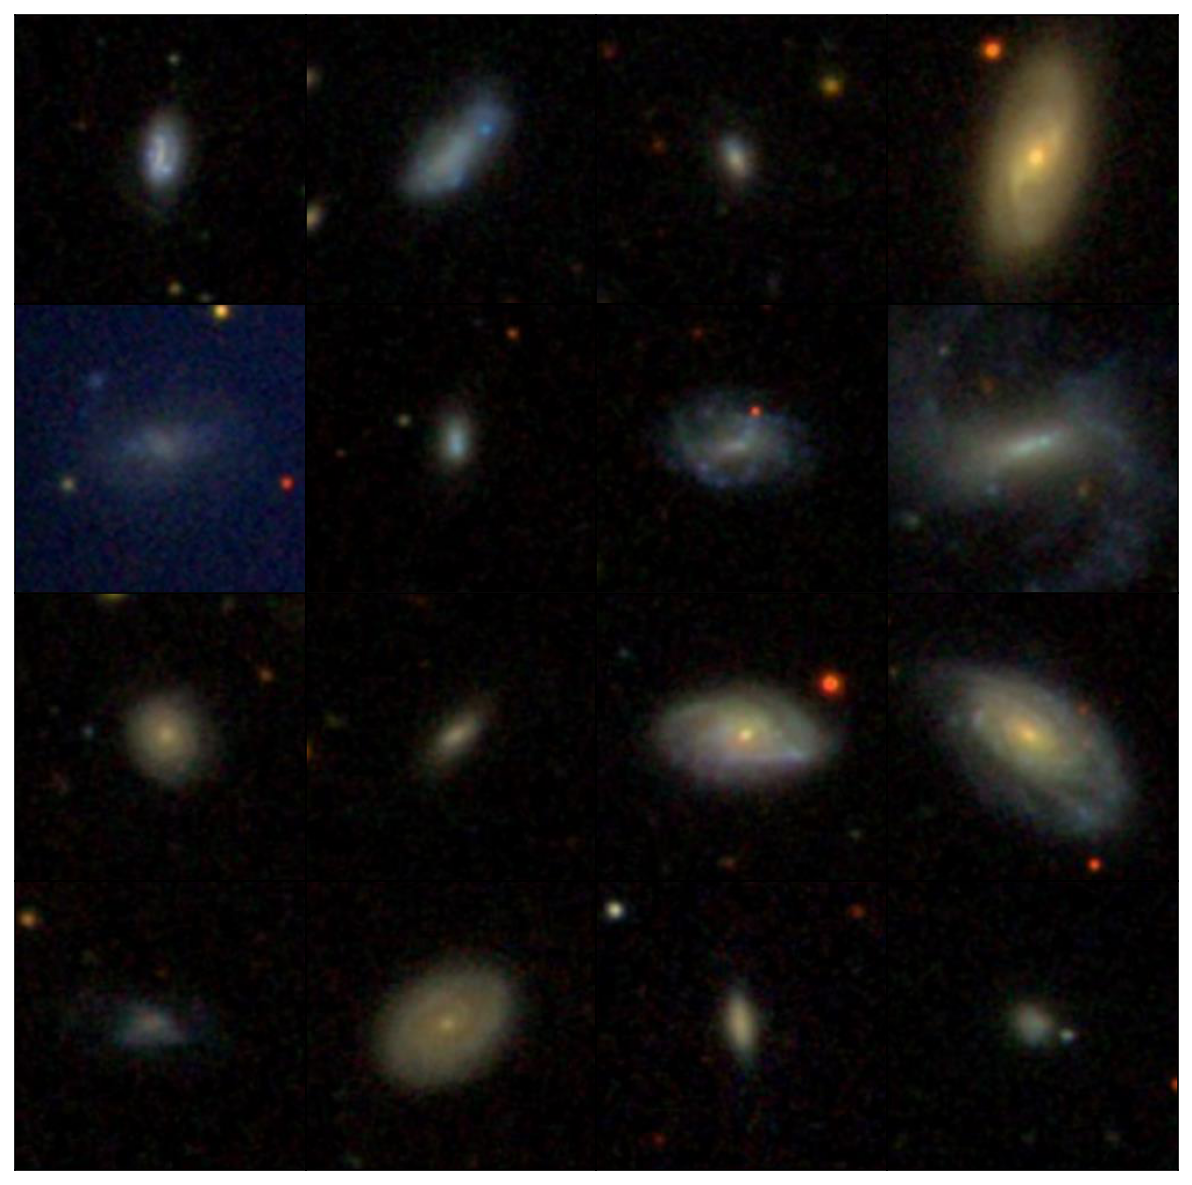

In [77]:
# basic selection example
isel = (ba > 0.4) & (10 < d_l) & (d_l < 150)  & (class_labels == 2)

# make a 4 x 4 image collage
nrow, ncol = 4, 4
ngal = nrow * ncol 

inds = np.random.choice(ra[isel].size, size=ngal, replace=False)
                        
# select indices of ngal objects from the objects that satisfy selection criteria
objids, ras, decs = objid[isel][inds], ra[isel][inds], dec[isel][inds]

# now display images on a grid
sdss_img_collage(objids, ras, decs, nrow=nrow, ncol=ncol, scale=0.2) 

0.3581232404127112


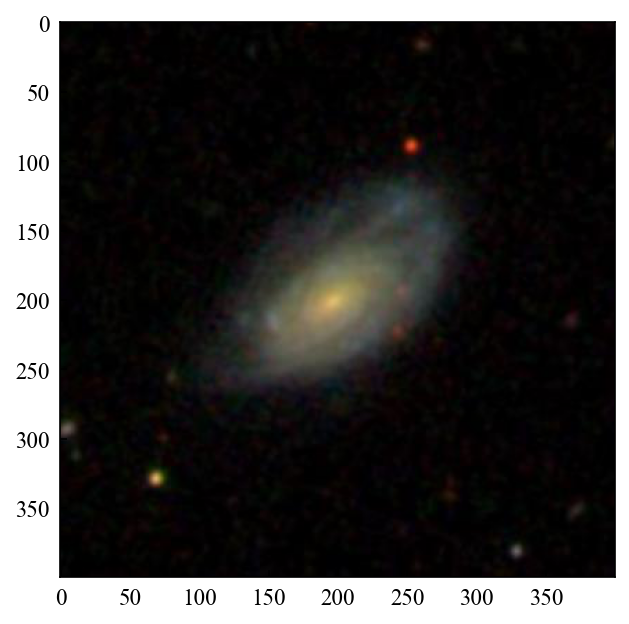

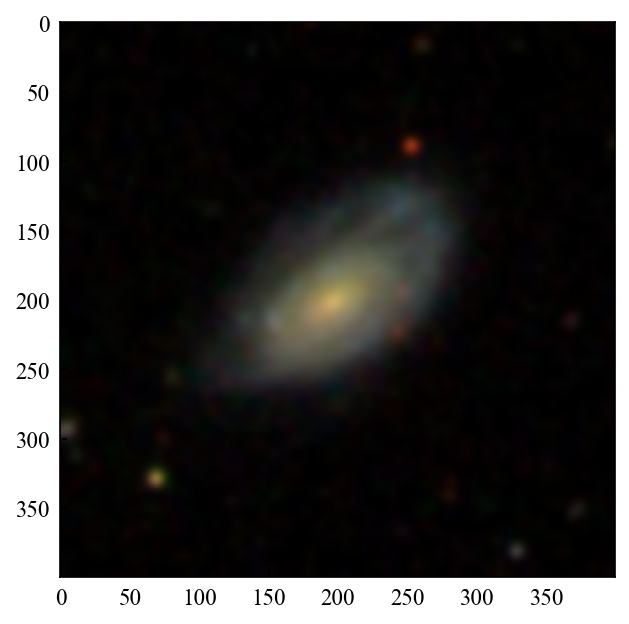

In [128]:
##Step 2 (with suggested fixes)
from scipy.ndimage import gaussian_filter
def get_blurring(img_ids, z_blur, lambda_JWST, scale = .262, d_l = d_l, z = z, objid = objid, ra = ra, dec = dec):
    '''retrieve the blurring factor at some higher redshift at a redhsift value 
    given an input image id corresponding to an SDSS image, a wavelength in microns
    and a desired redshift of an galaxy in JWST'''
    index = np.where(objid == img_ids)[0][0]
    d_l1 = d_l[index]
    z1 = z[index]
    ra1 = ra[index]
    dec1 = dec[index]
    dA = d_l1 / ((1+z1)**2)
    aspix = (scale*np.pi) / (60*60*180)
    ppix = aspix * dA #physical size of pixels in Mpc
    #now create an array of constant redshift values at some arbitrary higher redshift
    z2 = z_blur
    d_l2 = d_l_astropy(z2, 70, .3, .7)
    dA2 = d_l2 / ((1+z2)**2)
    #now we can calculate angular size of pixels at new redshift z = 4 for all of our galaxies.
    aspix2 = ppix / dA2 
    wavelength = lambda_JWST * 10**(-6) #observing at a wavelength of two microns
    diff_lim = 1.22 * wavelength / 6.5
    JWSTpix_size = diff_lim / 2
    blurring_factor = aspix2 / JWSTpix_size
    print(blurring_factor)
    dim_factor = ((1+z2)**4)/((1+z_blur)**4)
    outfile = 'img_sdss/'+str(objid)+'.jpg'
    fetch_sdss_image(outfile, ra1, dec1)
    gal_img = Image.open(outfile)
    return blurring_factor, dim_factor, ra1, dec1, gal_img

blur_im1, dim_im1, ra1, dec1, gal_img = get_blurring(objids[11], 4, 2)
plt.imshow(gal_img)
plt.show()

def gaussian_blur_dim(img, blur_fact, dim_fact):
    sigma = 1/blur_fact #higher number means more blurring
    blurred = gaussian_filter(img, sigma=(sigma, sigma, 0))
    return blurred
blurred = gaussian_blur_dim(gal_img, blur_im1, dim_im1)
plt.imshow(blurred)


The JWST filter F070W corresponds to the SDSS filter u


The JWST filter F090W corresponds to the SDSS filter u


The JWST filter F115W corresponds to the SDSS filter u


The JWST filter F150W corresponds to the SDSS filter u


The JWST filter F200W corresponds to the SDSS filter u


The JWST filter F277W corresponds to the SDSS filter r


The JWST filter F356W corresponds to the SDSS filter i


The JWST filter F444W corresponds to the SDSS filter i



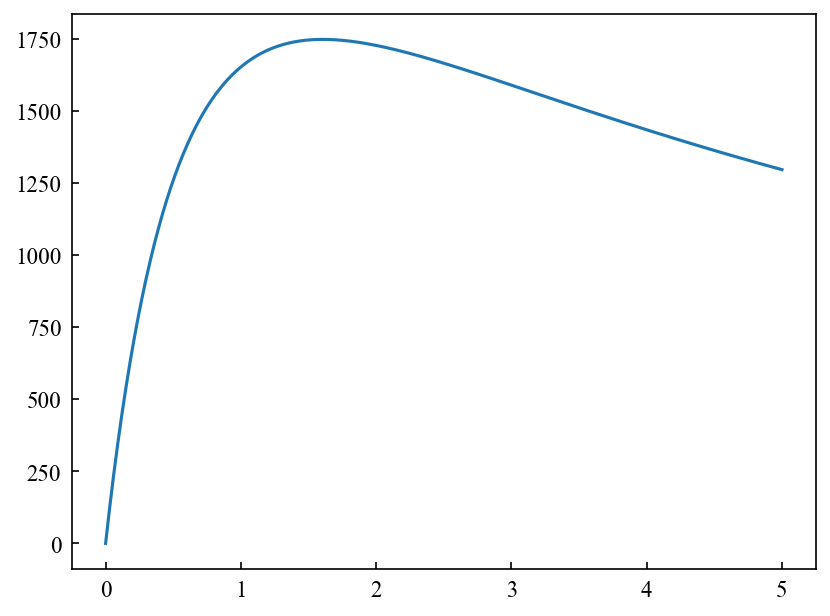

In [139]:
def JWST_To_ugri(lam, z):
    filt_list= []
    for i in range(0, len(lam)):
        ugri_val = np.array([.355, .468, .616, .748])
        ugri = ['u', 'g', 'r', 'i']
        shrink_factor = 1/(1+z)
        SDSS_lam = lam[i]*shrink_factor
        mod_arr = np.abs(ugri_val-SDSS_lam)
        filter_ind = np.where(mod_arr==np.min(mod_arr))[0][0]
        filter = ugri[filter_ind]
        filt_list.append(filter)
    return filt_list
JWST_filt_name = ['F070W', 'F090W', 'F115W', 'F150W', 'F200W', 'F277W', 'F356W', 'F444W',]
lam = np.array([.7, .9, 1.15, 1.5, 2, 2.77, 3.56, 4.44])

filts = JWST_To_ugri(lam, 4)

for i in range(len(JWST_filt_name)):
    print('\n' + f'The JWST filter {JWST_filt_name[i]} corresponds to the SDSS filter {filts[i]}' '\n')
    
redshift = np.linspace(0, 5, 500)
DA = d_l_astropy(redshift, 70, .3, .7)/((1+redshift)**2)
plt.plot(redshift, DA)

Now, Using the RA and Dec we recieved from our function, we can find a legacy image and blur that image instead, and then comment on our ability to see whether or not we have a disc galaxy or not in specific filter bands that correspond to specific JWST filters. 

In [130]:
def legacy_viewer_url(ra, dec, zoom=None, width=400, height=400, pixscale=1, layer='ls-dr9'):
    '''
    Construct URL to get an image from the Legacy Survey viewer for a quick check
    '''
    base_url = 'https://www.legacysurvey.org/viewer/jpeg-cutout?'
    if zoom is not None: 
        url = base_url + f'ra={ra}&dec={dec}&zoom={zoom}&layer={layer}'
    else: 
        url = base_url + \
        f'ra={ra}&dec={dec}&zoom={zoom}&pixscale={pixscale}&width={width}&height={height}&layer={layer}'
    return url

from matplotlib.colors import LogNorm

def plot_image(image, minsubtract=True, title=None, figsize=(10,10)):
    '''
    Plots an image using pixels in the input 2d list or NumPy array image
    '''
    if minsubtract:
        # Determine the minimum of image pixel values using "list comprehension"
        #imin = min([min(row) for row in image]) # min() is a built-in function for finding minimum of a simple list
        # Subtract the minimum from each image pixel using nested list comprehension
        #image_ = [[(x - imin) for x in row] for row in image]
        image_ = image - image.min()
    else:
        image_ = image
        
        
    # Now plot the image with Matplotlib
    # Define a single panel plot of a given size
    fig, ax = plt.subplots(1,1, figsize=figsize)
    # Display image in list image using 'gray' colormap on a log stretch
    ax.imshow(image_, cmap='gray', norm=LogNorm(), origin='lower') 
    _ = ax.axis('off') # Do not plot axis ticks
    # Display plot title with the specified string
    if title is not None: ax.set_title(title)
    plt.show() # Show the plot
    
import os

DECaLS_pixel_scale = 0.262

def download_decals_cutout(ra, dec, size, band, layer='ls-dr9', pixel_unit=False, 
                    output_dir='./', output_name='DECaLS_img', overwrite=False, 
                    verbose=False):
    '''
    Download DECaLS small image cutout of a given image. Maximum size is 3000 * 3000 pix.
    
    Parameters:
        ra (float): RA (degrees)
        dec (float): DEC (degrees)
        size (float): image size in pixel or arcsec. If pixel_unit = True, it's in pixel.
        band (string): such as 'r' or 'g'
        layer (string): data release of DECaLS. If your object is too north, try 'dr9-north'. 
            For details, please check http://legacysurvey.org/dr9/description/.
        pixel_unit (bool): If true, size will be in pixel unit.
        output_dir (str): directory of output files.
        output_name (str): prefix of output images. The suffix `.fits` will be appended automatically. 
        overwrite (bool): overwrite files or not.
    Return:
        None
    '''
    import urllib

    if pixel_unit is False:
        s = size / DECaLS_pixel_scale
    else:
        s = size
    
    base_url = f'http://legacysurvey.org/viewer/fits-cutout?'
    url = base_url+f'ra={ra}&dec={dec}&pixscale={DECaLS_pixel_scale}&layer={layer}&size={s:.0f}&bands={band}'
    print(url)
    filename = output_dir + output_name + '_' + band + '.fits'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url, filename=filename, data=None)
        if verbose: print('# Downloading ' + filename + ' finished! ') 
    elif os.path.isfile(filename) and overwrite:
        os.remove(filename)
        urllib.request.urlretrieve(url, filename=filename, data=None)
        if verbose: print('# Downloading ' + filename + ' finished! ')                            
    elif os.path.isfile(filename) and not overwrite:
        print('!!!The image "' + filename + '" already exists!!!')
    return

from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_area
from astropy.visualization import make_lupton_rgb


DECaLS_pixel_scale = 0.262

class LegacyField:
    
    def __init__(self, ra=None, dec=None, size=300, filters=['g', 'r', 'z'], 
                 output_dir='./legacy_data/', output_name='DECaLS_img', overwrite=False):

        # check if images exist and download if they don't
        for f in filters:
            download_decals_cutout(ra, dec, size, f, layer='ls-dr9', pixel_unit=False, 
                                output_dir=output_dir, output_name=output_name, overwrite=overwrite)
        # load images and their FITS headers into dictionaries for convenience
        self.images = {}
        self.img_headers = {}
        self.img_bg_stats = {}
        for f in filters:
            hdu = fits.open(output_dir + output_name + f'_{f}.fits')
            self.images[f] = hdu[0].data
            self.img_headers[f] = hdu[0].header
            hdu.close()
        
        # if filters contains more than one filter construct 
        # combined image by adding images in individual filters 
        # and record dictionary key of the combined image 
        if len(filters) > 1:
            key = filters[0]
            comb_image = np.copy(self.images[key])
            for f in filters[1:]:
                key += f
                comb_image += self.images[f]
            self.images[key] = comb_image
            self.comb_image_key = key
        else:
            key = filters[0]
            self.comb_image_key = key # if input contains a single filter

        
    def plot_filter(self, f=None, minsubtract=True, title=None, figsize=(5,5)):
        if f is not None:
            print(np.shape(self.images[f]))
            
            plot_image(self.images[f], minsubtract=minsubtract, title=title, figsize=figsize)

            # right ascension and declination of the center of the image


url = legacy_viewer_url(ra1, dec1, pixscale=0.5, zoom=12)

print(url)


https://www.legacysurvey.org/viewer/jpeg-cutout?ra=149.06199645996094&dec=20.495800018310547&zoom=12&layer=ls-dr9


In [135]:

# size of the field around RA and DEC in arcsec
size = 50

# get images in g, r, z filters of the field 
os.makedirs('legacy_data', exist_ok=True)
field = LegacyField(ra=ra1, dec=dec1, size=size, filters=['g', 'r', 'z'], output_name='galaxy127')

http://legacysurvey.org/viewer/fits-cutout?ra=149.06199645996094&dec=20.495800018310547&pixscale=0.262&layer=ls-dr9&size=191&bands=g
http://legacysurvey.org/viewer/fits-cutout?ra=149.06199645996094&dec=20.495800018310547&pixscale=0.262&layer=ls-dr9&size=191&bands=r
http://legacysurvey.org/viewer/fits-cutout?ra=149.06199645996094&dec=20.495800018310547&pixscale=0.262&layer=ls-dr9&size=191&bands=z


(191, 191)


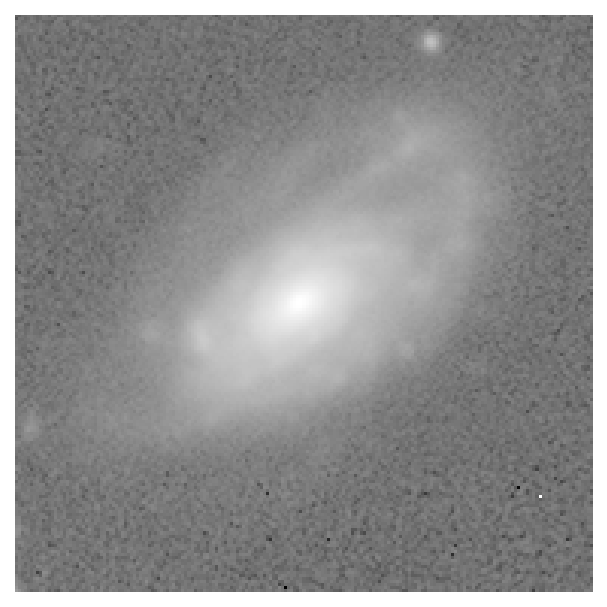

In [136]:
field.plot_filter(f='r')

[[ 0.06078989  0.03445097  0.01666048 ...  0.00882851  0.01050428
   0.00626332]
 [ 0.03940923  0.01429522  0.0122986  ...  0.00035189 -0.00155455
   0.00706242]
 [ 0.02501483  0.01502799  0.01124728 ... -0.00141179 -0.00877509
  -0.00065833]
 ...
 [ 0.00291055  0.004572   -0.00400837 ... -0.00392317 -0.00026563
  -0.00857443]
 [-0.01336522 -0.00088338  0.00159145 ...  0.00022862  0.00060962
  -0.00966007]
 [-0.00761372 -0.00974824 -0.00371241 ...  0.00469174 -0.00276477
   0.01012699]]
(191, 191)


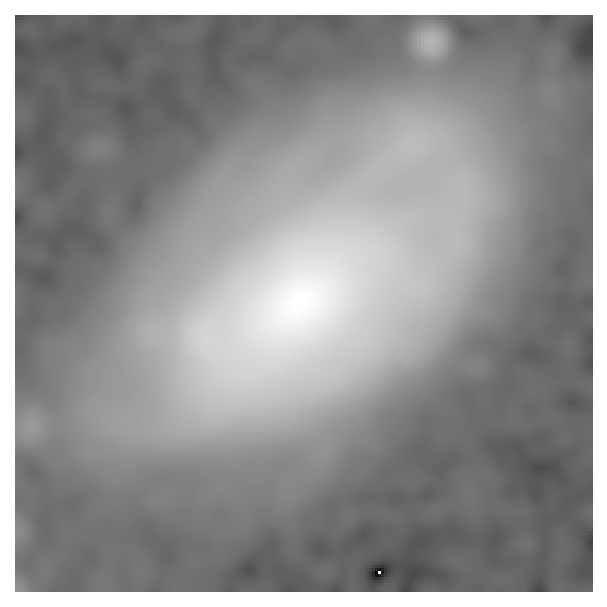

In [137]:
img = field.images['r']
print(img)

#we need to define a new blurring function for black and white images
#as they have a different amount of dimensions to the colored images
blur_im = blur_im1.value
def gaussian_blur_dim_bw(img, blur_fact, dim_fact):
    sigma = 1/blur_fact #higher number means more blurring
    blurred = gaussian_filter(img, sigma=sigma)
    return blurred

field.images['r']= gaussian_blur_dim_bw(img, blur_im, dim_im1)

field.plot_filter(f='r')